#Hands On Machine Learning Chapter 2!

This program was ran in Google Colab, and in some sections refers to files located in google drive. It is recommeded that this notebook be uploaded and ran in google drive via a .ipynb (Jupyter notebooks) file. 

All code in the first section was taken from Hands On Machine Learning by Aurélien Géron. The map making section is a combination of my own code and HOML2's chapter 2. Data is from a 1990 US Census, and focuses entirely on the state of California.

The first cell of code is an automated way of downloading the housing.tgz file from the author's github page and extracting the information.

In [57]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

NOTE: The code in the second printing of the book has since been updated. We are now using the sample code from the google collaboratory. If you use the code in the book you will get an error because of a few minor changes that need to happen. You can find the [google collab repository here](https://github.com/ageron/handson-ml2). 

In [58]:
fetch_housing_data(HOUSING_URL, HOUSING_PATH)

Now we are going to write a function that pushes the housing.csv into a pandas Data Frame

In [59]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, 'housing.csv')
  return pd.read_csv(csv_path)


Cool! Now we have a function to fetch the data, and a function to load the data into a data frame. 

In [60]:
import pandas as pd

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<function matplotlib.pyplot.show>

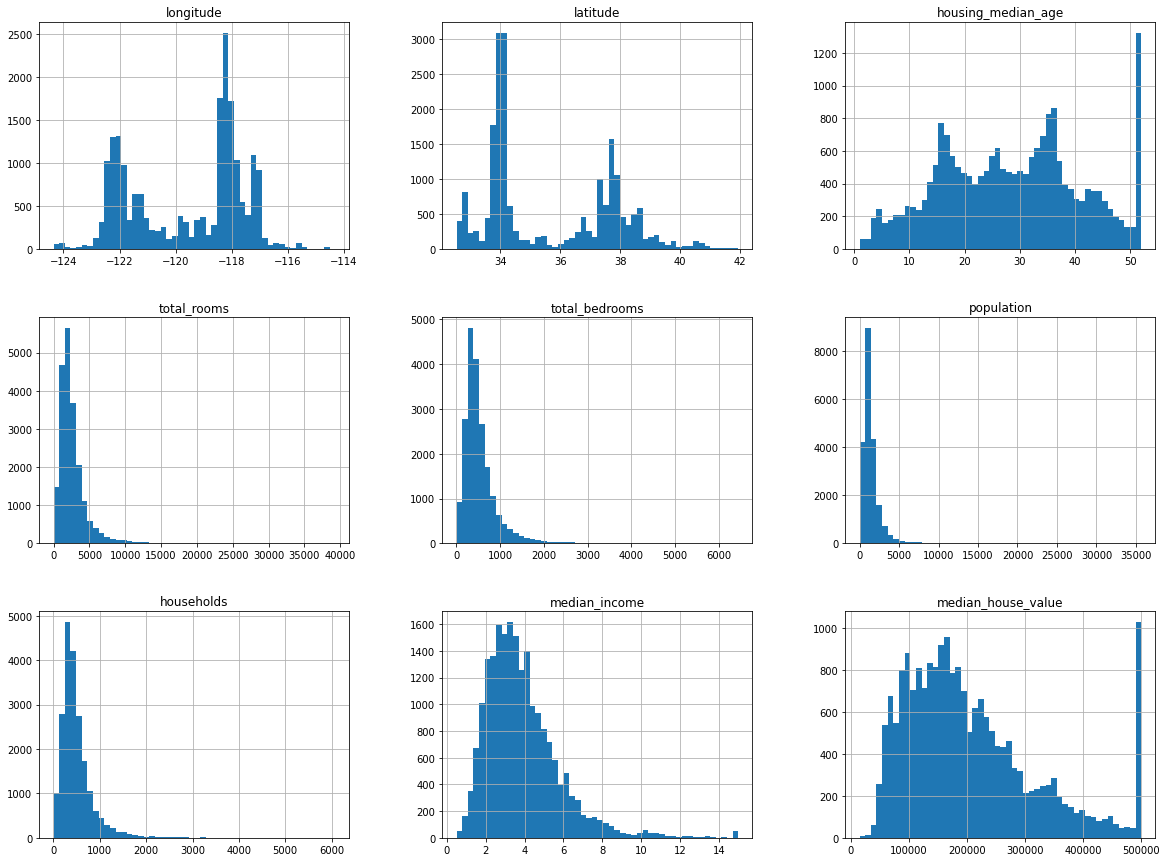

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins =50, figsize =(20,15))
plt.show


In [62]:
import numpy as np


def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]



In [63]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)


16512

In [64]:
len(test_set)

4128

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Next we're going to divide up our median income into categories ( 1 to 5 ). The rationale behind this is covered on page 54. 

In [67]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels=[1, 2, 3, 4, 5])

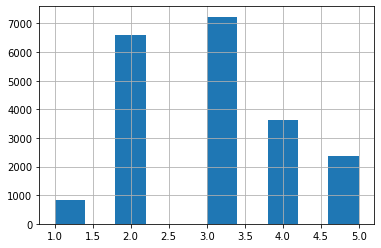

In [68]:
housing["income_cat"].hist();

We are now going to do some stratified sampling on the income category. We are going to use Scikit-Learn's StratifiedShuffleSplit class (seen below).

In [69]:
from sklearn.model_selection import StratifiedShuffleSplit

In [70]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

Let us now look at making maps.

#Map Making

Okay great so we did a bunch of shit in the cell blocks above, now we're going to do some data exploration! First we need to make a copy of our training set, so we don't mess up the original. 

In [88]:
housing_2 = strat_train_set.copy()

Since we have latitude an longitude, we can use this information to create a scatterplot of the districts. 

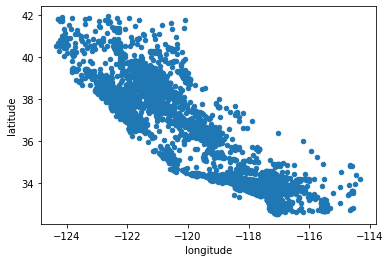

In [89]:
housing_2.plot(kind="scatter", x="longitude", y="latitude");

While this created a quick topographic map of california, I'm honestly unimpressed and would like to see a better representation. Let's scoure the internet until we can find a package/graph that looks better :)

Okay I'm back and have found what can only be described as the most straight forward tutorial i've found for this. We will be using a package called GeoPandas, in addition to [this website](https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972) which instructs us on how to create the map.

Let's get started! First we need to import all of the packages we need for our map. 

In [90]:
import sys

if 'google.colab' in sys.modules:
  !pip install -q geopandas
#the above code will tell google colab to install geopandas :D

import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

Sick, we got all our packages. Now we need a shapefile of California to feed geopandas as our basemap. We're going to use the one [from this website](https://data.ca.gov/dataset/ca-geographic-boundaries). 

Geopandas has a nice documentation on their website, found [here](https://geopandas.org/en/stable/docs/user_guide/io.html). 

[This page](https://neptune.ai/blog/google-colab-dealing-with-files) discusses dealing with files on google colab since it is slightly trickier. 

In [91]:
from google.colab import drive, files
import geopandas as gpd
import fiona

#this willl connect your drive to this notebook, accept and allow it to be linked.

drive.mount('/content/gdrive')

#you need to mount your drive to access files in the colab environment.
#once it's mounted, your files should appear in a separate window to the 
#left of your code. 



#run this twice to select the two shape files if not already in drive

### NOTE ### all files uploaded during session that are not permanently in your 
#drive will delete after the session is over


#uploaded = files.upload()
#uploaded = files.upload()

ca_county_path = "/content/gdrive/MyDrive/recreation/HOML/map_making/ca-county-boundaries/CA_Counties/CA_Counties_TIGER2016.shp"
ca_state_path = "/content/gdrive/MyDrive/recreation/HOML/map_making/ca-state-boundary/CA_State_TIGER2016.shp"

ca_county_shp = gpd.read_file(ca_county_path)

ca_state_shp = gpd.read_file(ca_state_path)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


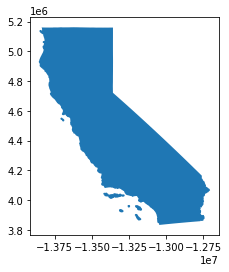

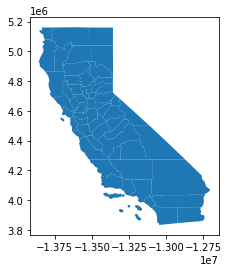

In [92]:
ca_state_shp.plot()
ca_county_shp.plot()

Looking much better already! Let's keep at it. We're going to use the counties file instead of the state one since it's a bit redundant to use both, and then plot our points from the dataset. We will also remove the axis.

In [93]:
data_points = pd.DataFrame()
#empty dataframe

data_points[['longitude', 'latitude']] = housing_2[['longitude', 'latitude']]
#stuffing that bad boy with lat and long like a nice ravioli

print(data_points.head())

data_points.info()

       longitude  latitude
12655    -121.46     38.52
15502    -117.23     33.09
2908     -119.04     35.37
14053    -117.13     32.75
20496    -118.70     34.28
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  16512 non-null  float64
 1   latitude   16512 non-null  float64
dtypes: float64(2)
memory usage: 387.0 KB


In [94]:
import matplotlib.pyplot as plt


In [95]:
base_map = ca_county_shp
points = gpd.GeoDataFrame(data_points)


x = data_points['longitude']
y = data_points['latitude']


#base_map.plot(x, y)
points.head()

,longitude,latitude
12655,-121.46,38.52
15502,-117.23,33.09
2908,-119.04,35.37
14053,-117.13,32.75
20496,-118.70,34.28


In [96]:
from geopandas.array import points_from_xy

gdf = gpd.GeoDataFrame(data_points, geometry=gpd.points_from_xy(data_points['longitude'], data_points['latitude']))


print(gdf.head())

       longitude  latitude                     geometry
12655    -121.46     38.52  POINT (-121.46000 38.52000)
15502    -117.23     33.09  POINT (-117.23000 33.09000)
2908     -119.04     35.37  POINT (-119.04000 35.37000)
14053    -117.13     32.75  POINT (-117.13000 32.75000)
20496    -118.70     34.28  POINT (-118.70000 34.28000)


It took a while to get the points on top of our base map, because our basemap had a different CRS than our geodataframe. To fix this, we use the to_crs() function. 

In [97]:
my_geoseries = base_map.to_crs("EPSG:4326")

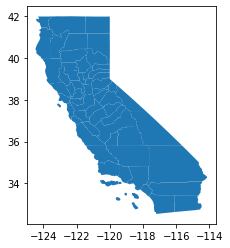

In [98]:
my_geoseries.plot()

Above we have our shape file of CA counties. Neat! Now we will add our lat and long points from our dataset. 

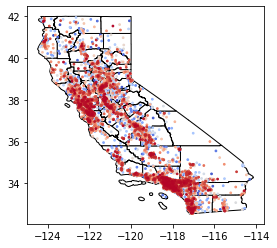

In [99]:
base = my_geoseries.plot(color='white', edgecolor='black')

gdf.plot(ax=base, marker='o', cmap="coolwarm", markersize=3, figsize= 50);

which looks nicer? The above or the below?

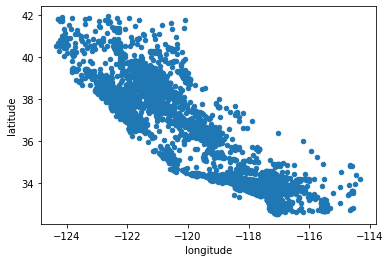

In [100]:
housing_2.plot(kind="scatter", x="longitude", y="latitude");

Yeah, it's kind of no contest with the one above. 

Using the cmap argument to change the points from a uniform color to a color map that changes in areas of high density. Color palettes to chose from include: 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean',

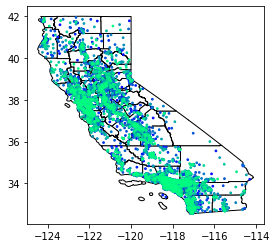

In [101]:
base = my_geoseries.plot(color='white', edgecolor='black')

gdf.plot(ax=base, marker='o', cmap='winter', markersize=3, alpha = 1, figsize= (50, 50));

We're going to clean this map up a little bit, taking a lot of code from HOML2 Chapter 2. 

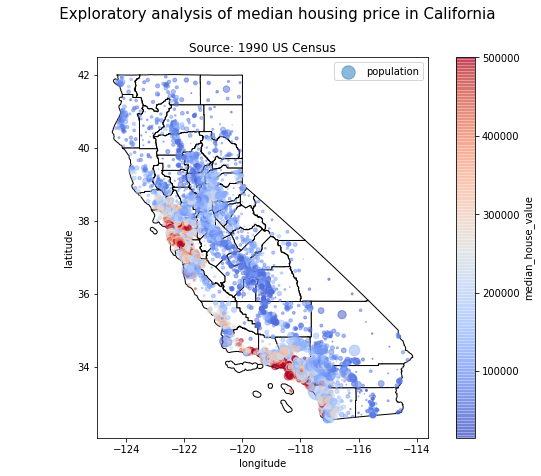

In [102]:
base = my_geoseries.plot(color='white', edgecolor='black')

housing.plot(ax = base, kind='scatter', x='longitude', y='latitude', alpha=0.5,
             s=housing['population']/100, label='population', figsize=(10,7),
             c='median_house_value', cmap=plt.get_cmap('coolwarm'), colorbar=True)

plt.suptitle("           Exploratory analysis of median housing price in California", fontsize=15) #the spaces center the title to the figure
plt.title("Source: 1990 US Census")
plt.legend();

And there we have it. A nice, neat color map that gives us information on a few key attributes! The first, and most obvious, being a topographic map of the state of california. The second being our median house price represented by the color palette. The third being our population size, based on how large or small the plotted points are (larger circle = larger population). 